In [ ]:
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 관련 라이브러'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report 

'''알고리즘 관련 라이브러'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)


unset HISTFILE; export PS1="root@c0b4e1d53adf-8b406c3768fc49e1a5bf9d60fd9db0fb: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@c0b4e1d53adf-8b406c3768fc49e1a5bf9d60fd9db0fb: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@c0b4e1d53adf-8b406c3768fc49e1a5bf9d60fd9db0fb: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@c0b4e1d53adf-8b406c3768fc49e1a5bf9d60fd9db0fb: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 115
root@c0b4e1d53adf-8b406c3768fc49e1a5bf9d60fd9db0fb: cat /tmp/tmprjqwgf_2/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:1

In [ ]:
os.chdir('./drive/MyDrive/dacon study/')

In [ ]:
data = pd.read_csv('./creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#피처 행렬 및 레이블 배열 생성
dataX=data.copy().drop(['Class'],axis=1)
dataY=data['Class'].copy()

In [ ]:
featureToScale=dataX.drop(['Time'],axis=1).columns
featureToScale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [ ]:
ss=pp.StandardScaler(copy=True)
dataX.loc[:,featureToScale]=ss.fit_transform(dataX[featureToScale])

In [ ]:
scalingFactors=pd.DataFrame(data=[ss.mean_,ss.scale_],index=['Mean','Std'],columns=featureToScale)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataX, 
                                    dataY, test_size=0.2, 
                                    random_state=2018, stratify=dataY)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model=lgb.LGBMClassifier(boosting_type='gbdt',objective='binary')

In [ ]:
param_grid={
    'bagging_fraction': [0.6, 0.8, 1.0],
    'feature_fraction': [1.0],
    'max_depth':[4],
    'learning_rate':[0.01]
}

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

In [ ]:
gcv=GridSearchCV(model, param_grid=param_grid, cv=folds,  n_jobs=-1)# n_jobs=-1 ->가용할 수 있는 최대

In [ ]:
gcv.fit(train_x, train_y)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력

final params {'bagging_fraction': 0.6, 'feature_fraction': 1.0, 'learning_rate': 0.01, 'max_depth': 4}


In [ ]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric_freq':50,
    # 'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.6,
    # 'bagging_freq': 0,
    # 'bagging_seed': 2018,
    'verbose': 1,
    'num_threads':-1
}

In [ ]:
logloss_scores = []

for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    print(f'===================================={n_fold+1}============================================')
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=1000,
                   valid_sets=lgb_eval, early_stopping_rounds=50)

    predictions=gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
    logloss=log_loss(y_val, predictions)
    logloss_scores.append(logloss)
    print(f"FOLD {n_fold} : logloss:{logloss}")
    print(f'================================================================================\n\n')
        
mean_outcome=np.mean(logloss_scores)
print("Mean:{}".format(mean_outcome))


====================================1============================================
[1]	valid_0's binary_logloss: 0.00602334
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.0059382
[3]	valid_0's binary_logloss: 0.00585884
[4]	valid_0's binary_logloss: 0.00578755
[5]	valid_0's binary_logloss: 0.00572073
[6]	valid_0's binary_logloss: 0.00564981
[7]	valid_0's binary_logloss: 0.00558035
[8]	valid_0's binary_logloss: 0.00550492
[9]	valid_0's binary_logloss: 0.00544261
[10]	valid_0's binary_logloss: 0.00539505
[11]	valid_0's binary_logloss: 0.00534218
[12]	valid_0's binary_logloss: 0.00529083
[13]	valid_0's binary_logloss: 0.00523784
[14]	valid_0's binary_logloss: 0.0051879
[15]	valid_0's binary_logloss: 0.00514456
[16]	valid_0's binary_logloss: 0.00510083
[17]	valid_0's binary_logloss: 0.00505798
[18]	valid_0's binary_logloss: 0.00501663
[19]	valid_0's binary_logloss: 0.00497292
[20]	valid_0's binary_logloss: 0.00492631
[21]	valid_0's binary_loglo

In [ ]:
pred_y = gbm.predict(test_x)
print(pred_y)

[1.09846735e-05 7.62306112e-05 1.11229172e-05 ... 2.45728973e-04
 4.10514915e-05 6.95237834e-05]


In [ ]:
predict_y = []
for i in pred_y:
    if i > 0.5:
        predict_y.append(1)
    else:
        predict_y.append(0)

In [ ]:
predictions_lgbm = np.where(pred_y > 0.5, 1, 0)

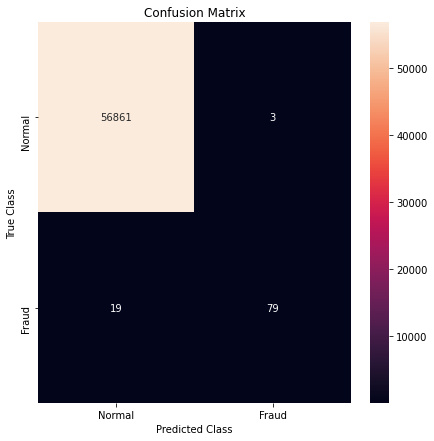

In [ ]:
LABELS = ['Normal', 'Fraud']

conf_matrix = confusion_matrix(test_y, predictions_lgbm)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [ ]:
f1_score(test_y, predict_y, average='macro')

0.9387921804910833

In [ ]:
params_XGB = {
    'nthread':-1, 
    'learning rate': 0.3, #range 0 to 1, default 0.3
    # 'gamma': 0, #range 0 to infinity, default 0 
    'max_depth': 6, #range 1 to infinity, default 6
    # 'min_child_weight': 1, #range 0 to infinity, default 1
    # 'max_delta_step': 0, #range 0 to infinity, default 0
    'subsample': 1.0, #range 0 to 1, default 1
    'colsample_bytree': 1.0, #range 0 to 1, default 1 #subsample,colsample_bytree는 0.1일때 가장 효율을 보일때가 많음
    'objective':'binary:logistic',
    'num_class':1,
    'eval_metric':'logloss',
    'seed':2018,
    'verbosity':1
}

In [ ]:
logloss_scores = []

for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    print(f'===================================={n_fold+1}============================================')
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

    d_train = xgb.DMatrix(X_train, y_train)
    d_val = xgb.DMatrix(data=X_val)
    
    # beset_round를 찾아줌
    # bst = xgb.cv(params_XGB, d_train, num_boost_round=1000, 
    #              nfold=5, early_stopping_rounds=30, verbose_eval=50)
    # best_rounds = np.argmin(bst['test-logloss-mean'])

    xgb_model = xgb.train(params_XGB, d_train, num_boost_round=50)

    predictions=xgb_model.predict(d_val)
    
    logloss=log_loss(y_val, predictions)
    logloss_scores.append(logloss)
    print(f"FOLD {n_fold} : logloss:{logloss}")
    print(f'================================================================================\n\n')
        
mean_outcome=np.mean(logloss_scores)

print("Mean:{}".format(mean_outcome))

====================================1============================================
FOLD 0 : logloss:0.002437473749085344


====================================2============================================
FOLD 1 : logloss:0.0033118757368844846


====================================3============================================
FOLD 2 : logloss:0.0030240022163758934


====================================4============================================
FOLD 3 : logloss:0.00330645536140837


====================================5============================================
FOLD 4 : logloss:0.002317661517398145


Mean:0.0028794937162304477


In [ ]:
d_test = xgb.DMatrix(data=test_x) ##xgb포맷에 맞춰주기
pred_y = xgb_model.predict(d_test)
print(pred_y)

[3.3759056e-06 3.6513029e-05 2.7726139e-06 ... 1.8332654e-04 1.8696661e-05
 2.5027235e-05]


In [ ]:
predictions_xgb = np.where(pred_y > 0.5, 1, 0)

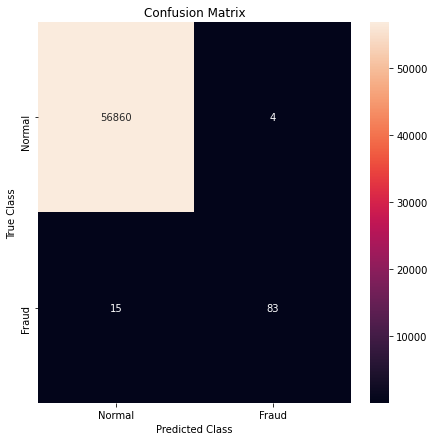

In [ ]:
LABELS = ['Normal', 'Fraud']

conf_matrix = confusion_matrix(test_y, predictions_xgb)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [ ]:
f1_score(test_y, predictions_xgb, average='macro')

0.9485651240880318

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=ad968c630e6c859600a0c78354110e23da52da052ba2bc695ea43f343693faeb
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
dtrain = xgb.DMatrix(train_x, train_y)

In [2]:
def xgb_evaluate(max_depth, subsample, colsample_bytree, learning_rate):
    params = {    
                'nthread':-1, 
                'learning rate':learning_rate, #range 0 to 1, default 0.3
                # 'gamma': 0, #range 0 to infinity, default 0 
                'max_depth': int(max_depth), #range 1 to infinity, default 6
                # 'min_child_weight': 1, #range 0 to infinity, default 1
                # 'max_delta_step': 0, #range 0 to infinity, default 0
                'subsample': subsample, #range 0 to 1, default 1
                'colsample_bytree': colsample_bytree, #range 0 to 1, default 1 
                'objective':'multi:softprob',
                'num_class':1,
                'eval_metric':'logloss',
                'seed':2018,
                'verbosity':1
             }

    cv_result = xgb.cv(params, dtrain, num_boost_round=50, nfold=5, early_stopping_rounds=50, seed=508)    

    # 최적화로 사용할 metric 반환
    # test-logloss-mean 값을 기준으로 마이너스 값이 출력 되므로 -1을 곱하여 return
    return -1.0 * cv_result['test-logloss-mean'].iloc[-1]

In [ ]:
# 실험해보고자하는 hyperparameter 집합 범위 설정
xgb_bo = BayesianOptimization(xgb_evaluate, 
                              {
                                'max_depth': (4, 10),
                                'subsample': (0.6, 1.0),
                                'colsample_bytree' :(0.6, 1.0),
                                'learning_rate': (0.01, 0.2)}
                              )

In [ ]:
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 
# xi : exploration 강도 (기본값은 0.0)
xgb_bo.maximize(init_points=5, n_iter = 3, acq='ei', xi=0.01, random_state=409)

|   iter    |  target   | colsam... | learni... | max_depth | subsample |
-------------------------------------------------------------------------
|  1        | -0.002749 |  0.9939   |  0.03015  |  4.395    |  0.701    |
|  2        | -0.002845 |  0.7124   |  0.1932   |  7.246    |  0.9058   |
|  3        | -0.002982 |  0.86     |  0.117    |  7.187    |  0.783    |
|  4        | -0.002898 |  0.6217   |  0.1573   |  8.476    |  0.8533   |
|  5        | -0.002942 |  0.9122   |  0.1189   |  8.865    |  0.7911   |
|  6        | -0.002875 |  0.786    |  0.1014   |  4.03     |  0.876    |
|  7        | -0.00298  |  0.8157   |  0.1213   |  9.928    |  0.8168   |
|  8        | -0.002883 |  0.8505   |  0.1402   |  4.007    |  0.746    |


In [ ]:
 params = {    
                'nthread':-1, 
                'learning rate':0.067, #range 0 to 1, default 0.3
                # 'gamma': 0, #range 0 to infinity, default 0 
                'max_depth': 7, #range 1 to infinity, default 6
                # 'min_child_weight': 1, #range 0 to infinity, default 1
                # 'max_delta_step': 0, #range 0 to infinity, default 0
                'subsample': 0.869, #range 0 to 1, default 1
                'colsample_bytree': 0.7967, #range 0 to 1, default 1 
                'objective':'binary:logistic',
                'num_class':1,
                'eval_metric':'logloss',
                'seed':2018,
                'verbosity':1
             }

In [ ]:
model = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    verbose_eval = 50
)
model

[0]	train-logloss:0.437907+1.90263e-05	test-logloss:0.438043+5.12703e-05
[50]	train-logloss:0.000159+1.24579e-05	test-logloss:0.0028288+0.000752745


,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.437907,0.000019,0.438043,0.000051
1,0.297383,0.000048,0.297363,0.000094
2,0.207977,0.000156,0.208495,0.000118
3,0.149088,0.000060,0.149041,0.000165
4,0.107661,0.000073,0.108023,0.000178
5,0.078813,0.000071,0.078969,0.000230
6,0.057754,0.000070,0.058225,0.000277
7,0.042904,0.000156,0.043198,0.000319
8,0.031913,0.000084,0.032297,0.000350
9,0.023921,0.000098,0.024343,0.000373


In [ ]:
best_rounds = np.argmin(model['test-logloss-mean'])
print(best_rounds)

31


In [ ]:
logloss_scores = []

for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    print(f'===================================={n_fold+1}============================================')
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

    d_train = xgb.DMatrix(X_train, y_train)
    d_val = xgb.DMatrix(data=X_val)
    
    # beset_round를 찾아줌
    # bst = xgb.cv(params_XGB, d_train, num_boost_round=1000, 
    #              nfold=5, early_stopping_rounds=30, verbose_eval=50)
    # best_rounds = np.argmin(bst['test-logloss-mean'])

    xgb_model = xgb.train(params, d_train, num_boost_round=best_rounds)

    predictions=xgb_model.predict(d_val)
    
    logloss=log_loss(y_val, predictions)
    logloss_scores.append(logloss)
    print(f"FOLD {n_fold} : logloss:{logloss}")
    print(f'================================================================================\n\n')
        
mean_outcome=np.mean(logloss_scores)

print("Mean:{}".format(mean_outcome))

====================================1============================================
FOLD 0 : logloss:0.0023819524530918406


====================================2============================================
FOLD 1 : logloss:0.003323150085586332


====================================3============================================
FOLD 2 : logloss:0.002788900827373636


====================================4============================================
FOLD 3 : logloss:0.0029915231590383084


====================================5============================================
FOLD 4 : logloss:0.002195232165134086


Mean:0.0027361517380448406


In [ ]:
d_test = xgb.DMatrix(data=test_x)
pred_y = xgb_model.predict(d_test)
print(pred_y)

[5.2501378e-04 1.2074896e-04 7.8737132e-05 ... 1.8227413e-04 6.8886126e-05
 5.3034400e-05]


In [ ]:
predictions_xgb = np.where(pred_y > 0.5, 1, 0)

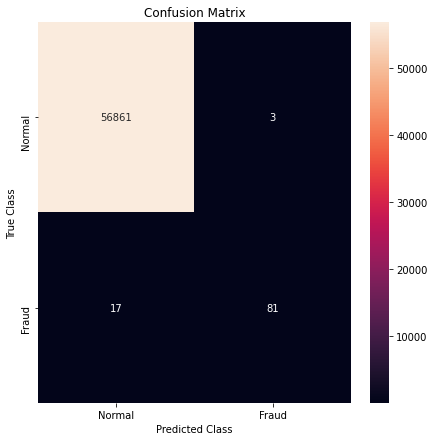

In [ ]:
LABELS = ['Normal', 'Fraud']

conf_matrix = confusion_matrix(test_y, predictions_xgb)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [ ]:
f1_score(test_y, predictions_xgb, average='macro')

0.94496702678377